# Jaws Segmentation Task

Hello, You're tasked with building a neural network using pytorch which segments upper (Maxilla) and lower(Mandible) jaws in a DICOM file

The Dataset is provided as 2D slices from all 3 orthogonal points of view Axial, Coronal, and Sagittal, if you're not familiar with what a DICOM is, you're expected to read online about it

Duration: 1 Week

Deliverables: This notebook (which should contain your solution), and any other files (like saved weights) in a **zip** file, and you mail this **zip** file to us

In [1]:
import boto3
import os
import pathlib
import ipywidgets
from IPython.display import display
from math import ceil
import torch
import gzip
import numpy as np
import glob
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np



In [2]:
BUCKET = 'cvml-datasets'
BUCKET_DATASET_PATH = 'jaws-segmentation/v1/public/2d'
LOCAL_DATASET_PATH = 'dataset'
BATCH_SIZE=16

## Downloading Dataset

In this part we download the publically available dataset, you can skip it if you already have it, it should be 512 MB worth of data

In [3]:
from botocore import UNSIGNED
from botocore.client import Config

In [12]:
def download_file(s3client, obj, to):
	key = obj['Key']
	filename = pathlib.Path(to).joinpath(*key.rsplit('/'))
	os.makedirs(filename.parent, exist_ok = True)
	s3client.download_file(Bucket=BUCKET, Key=key, Filename=str(filename))

def download_data(to=LOCAL_DATASET_PATH):
    #since our dataset is open-source , we can use unsigned signature version
	s3client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
	paginator = s3client.get_paginator('list_objects')
	page_iterator = paginator.paginate(Bucket=BUCKET, Prefix=BUCKET_DATASET_PATH)
	page_counter = 3
	for page in page_iterator:
		progress_bar = ipywidgets.IntProgress(min=0, max=len(page['Contents']), description=f'Page {page_counter}:')
		display(progress_bar)
		file_counter = 0
		for obj in page['Contents']:
			key = obj['Key']
			filename = pathlib.Path(to).joinpath(*key.rsplit('/'))
			os.makedirs(filename.parent, exist_ok = True)
			s3client.download_file(Bucket=BUCKET, Key=key, Filename=str(filename))
			progress_bar.value += 1
		page_counter += 1
download_data()

IntProgress(value=0, description='Page 3:', max=1000)

IntProgress(value=0, description='Page 4:', max=1000)

IntProgress(value=0, description='Page 5:', max=1000)

IntProgress(value=0, description='Page 6:', max=1000)

IntProgress(value=0, description='Page 7:', max=1000)

IntProgress(value=0, description='Page 8:', max=1000)

IntProgress(value=0, description='Page 9:', max=1000)

IntProgress(value=0, description='Page 10:', max=1000)

IntProgress(value=0, description='Page 11:', max=454)

## Explore The Dataset

In this section you should explore/plot the dataset and get familiar with it, we are nice enough to write a dataset loader for you and we did some initial visualization for you

In [3]:
class JawsDataset(torch.utils.data.Dataset):
	def __init__(self, dicom_file_list, transforms):
		self.dicom_file_list = dicom_file_list
		self.transforms = transforms

	def __len__(self):
		return len(self.dicom_file_list)

	def __getitem__(self, idx):
		dicom_path = self.dicom_file_list[idx]
		label_path = dicom_path.replace('.dicom.npy.gz', '.label.npy.gz')
		dicom_file = gzip.GzipFile(dicom_path, 'rb')
		dicom = np.load(dicom_file)
		label_file = gzip.GzipFile(label_path, 'rb')
		label = np.load(label_file)
		return self.transforms(dicom), self.transforms(label)

def axial_dataset_train(transforms, validation_ratio = 0.1):
	files = glob.glob('dataset/jaws-segmentation/v1/public/2d/axial/train/**/*.dicom.npy.gz')
	assert len(files) > 0
	validation_files_count = ceil(len(files) * validation_ratio)

	return (JawsDataset(files[validation_files_count:], transforms),
			JawsDataset(files[:validation_files_count], transforms))

def coronal_dataset_train(transforms, validation_ratio = 0.1):
	files = glob.glob('dataset/jaws-segmentation/v1/public/2d/coronal/train/**/*.dicom.npy.gz')
	assert len(files) > 0
	validation_files_count = ceil(len(files) * validation_ratio)

	return (JawsDataset(files[validation_files_count:], transforms),
			JawsDataset(files[:validation_files_count], transforms))

def sagittal_dataset_train(transforms, validation_ratio = 0.1):
	files = glob.glob('dataset/jaws-segmentation/v1/public/2d/sagittal/train/**/*.dicom.npy.gz')
	assert len(files) > 0
	assert len(files) > 0
	validation_files_count = ceil(len(files) * validation_ratio)

	return (JawsDataset(files[validation_files_count:], transforms),
			JawsDataset(files[:validation_files_count], transforms))

def axial_dataset_test(transforms):
	files = glob.glob('dataset/jaws-segmentation/v1/public/2d/axial/test/**/*.dicom.npy.gz')
	assert len(files) > 0
	return JawsDataset(files, transforms)

def coronal_dataset_test(transforms):
	files = glob.glob('dataset/jaws-segmentation/v1/public/2d/coronal/test/**/*.dicom.npy.gz')
	assert len(files) > 0
	return JawsDataset(files, transforms)

def sagittal_dataset_test(transforms):
	files = glob.glob('dataset/jaws-segmentation/v1/public/2d/sagittal/test/**/*.dicom.npy.gz')
	assert len(files) > 0
	return JawsDataset(files, transforms)


In [68]:
dataset_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((64, 64)) ])

In [69]:
axial_train_dataset, axial_validatiaon_dataset = axial_dataset_train(dataset_transforms)
coronal_train_dataset, coronal_validation_dataset = coronal_dataset_train(dataset_transforms)
sagittal_train_dataset, sagittal_validation_dataset = sagittal_dataset_train(dataset_transforms)


print(f'axial training dataset: {len(axial_train_dataset)} slice')
print(f'coronal training dataset: {len(coronal_train_dataset)} slice')
print(f'sagittal training dataset: {len(sagittal_train_dataset)} slice')


axial_train_loader = torch.utils.data.DataLoader(axial_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
coronal_train_loader = torch.utils.data.DataLoader(coronal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_train_loader = torch.utils.data.DataLoader(sagittal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)

axial training dataset: 902 slice
coronal training dataset: 1334 slice
sagittal training dataset: 1347 slice


In [80]:
axial_data_iter = iter(axial_train_loader)
images, labels = axial_data_iter.next()

def imgs_display(ima):
    plt.figure(figsize=(16, 4))
    for index in range(0, min(16, len(ima))):
        plt.subplot(2, 8, index + 1)
        plt.axis('off')
        plt.imshow(ima[index].numpy().squeeze(), cmap='bone')


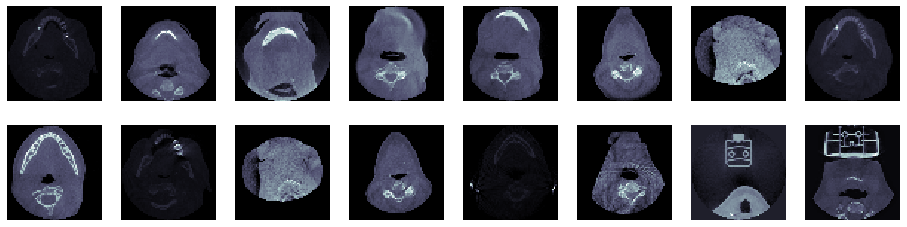

In [82]:
imgs_display(images)

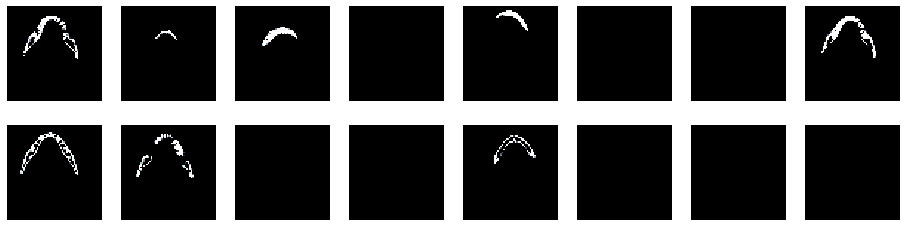

In [83]:
imgs_display(labels)

In [85]:
#images normalization

# get tensor image
img_tr = images[2]
  
# calculate mean and std
mean, std = img_tr.mean([1,2]), img_tr.std([1,2])
  
# print mean and std
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)

mean and std before normalize:
Mean of the image: tensor([-354.3656])
Std of the image: tensor([530.2782])


In [86]:
#visualizing images in detail
print (images[1],images[1].size(),torch.max(images[11]))
print (labels[1],labels[1].size(),torch.max(labels[11]))
print (labels[1].dtype)

tensor([[[-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
         [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
         [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
         ...,
         [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
         [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
         [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.]]]) torch.Size([1, 64, 64]) tensor(1668.5638)
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]) torch.Size([1, 64, 64]) tensor(0.)
torch.float32


In [87]:
def image_visualizer(image):
    img = np.squeeze(image)

    fig = plt.figure(figsize = (12,12)) 
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')
    
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(height):
        for y in range(32):
            val = np.round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

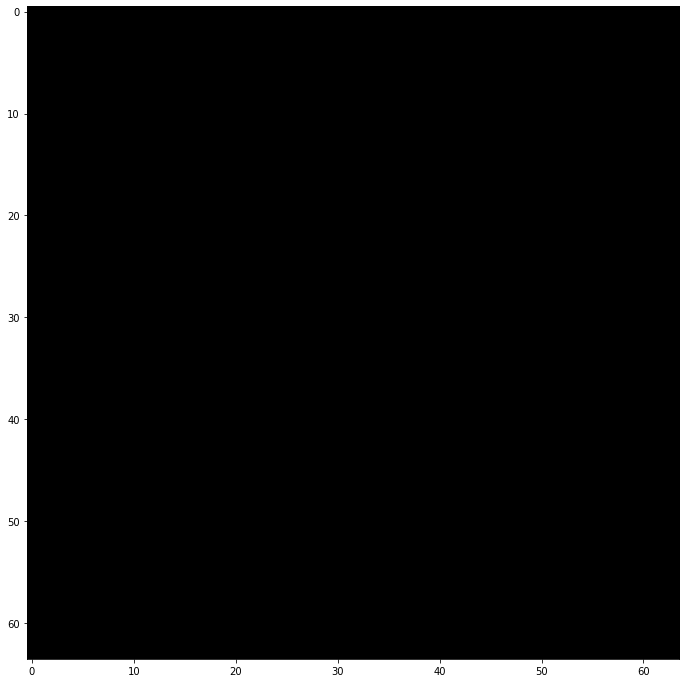

In [88]:
sample_image = labels[5]

image_visualizer(sample_image)

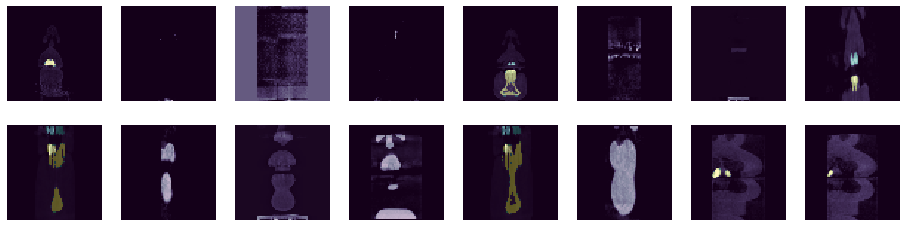

In [89]:
coronal_data_iter = iter(coronal_train_loader)
images, labels = coronal_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

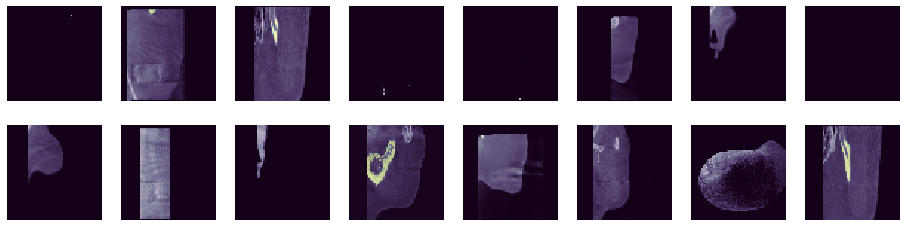

In [90]:
sagittal_data_iter = iter(sagittal_train_loader)
images, labels = sagittal_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

## Training

Now that you have downloaded the dataset and inspected it for a bit, you should train your model here, you can train a single model which works with all views (axial, sagittal, coronal), or you can train a model each, it's up to you

# Model stracture 

In [91]:
from unet import UNet
model = UNet(in_channels=1,
             out_channels=1,
             n_blocks=4,
             start_filts=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2)

x = torch.randn(size=(3, 1, 512, 512), dtype=torch.float32)
with torch.no_grad():
    out = model(x)

print(f'Out: {out.shape}')

Out: torch.Size([3, 1, 512, 512])


In [92]:
#from torchsummary import summary
#summary = summary(model, (1, 512, 512))

In [93]:
model=UNet()
print (model.out_channels)
print (model)

1
UNet(
  (down_convs): ModuleList(
    (0): DownConv(
      (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (act1): ReLU()
      (act2): ReLU()
      (norm0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): DownConv(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (act1): ReLU()
      (act2): ReLU()
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0

In [94]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = torch.nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [95]:
# number of epochs to train the model
n_epochs = 3

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in axial_train_loader:
        # move tensors to GPU if CUDA is available
#        if train_on_gpu:
#            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables

        data=data.float()
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
#        print (output[1].size())
#        print (target[1].size())            
        
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    print (data.type())
    #print (data , target,output)
    for data, target in axial_train_loader:
        # move tensors to GPU if CUDA is available
#        if train_on_gpu:
#            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        data=data.float()
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        
        valid_loss += loss.item()*data.size(0)
    #print ('output is ',output.item(),'......target is ',target.item())
    # calculate average losses
    train_loss =0#rain_loss/len(train_loader.sampler)
    valid_loss =0#alid_loss/len(valid_loader.sampler)
    #print (target)    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'MachineL_Learning.pt')
        valid_loss_min = valid_loss

torch.FloatTensor
Epoch: 1 	Training Loss: 0.000000 	Validation Loss: 0.000000
Validation loss decreased (inf --> 0.000000).  Saving model ...
torch.FloatTensor
Epoch: 2 	Training Loss: 0.000000 	Validation Loss: 0.000000
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
torch.FloatTensor
Epoch: 3 	Training Loss: 0.000000 	Validation Loss: 0.000000
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


## Testing

Now you should run your trained model on the test dataset available below and report your results

In [96]:
axial_test_dataset = axial_dataset_test(dataset_transforms)
coronal_test_dataset = coronal_dataset_test(dataset_transforms)
sagittal_test_dataset = sagittal_dataset_test(dataset_transforms)


print(f'axial testing dataset: {len(axial_test_dataset)} slice')
print(f'coronal testing dataset: {len(coronal_test_dataset)} slice')
print(f'sagittal testing dataset: {len(sagittal_test_dataset)} slice')

axial_test_loader = torch.utils.data.DataLoader(axial_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
coronal_test_loader = torch.utils.data.DataLoader(coronal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_test_loader = torch.utils.data.DataLoader(sagittal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)

axial testing dataset: 63 slice
coronal testing dataset: 90 slice
sagittal testing dataset: 91 slice


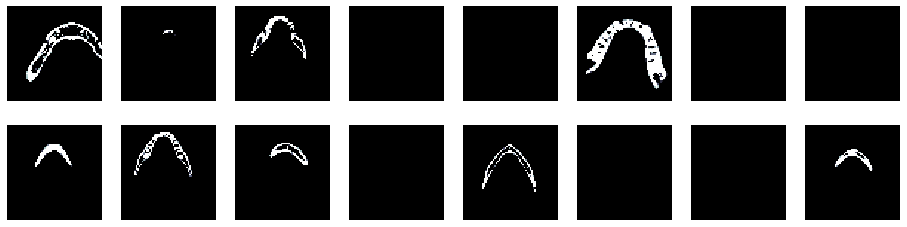

In [97]:
axial_data_iter = iter(axial_test_loader)
images, labels = axial_data_iter.next()

#displaying ground truth of test set
imgs_display(labels)


In [98]:
train_on_gpu = torch.cuda.is_available()

In [99]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in axial_test_loader:
    # move tensors to GPU if CUDA is available
#    if train_on_gpu:
#        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

print (output.size())

torch.Size([6, 1, 64, 64])


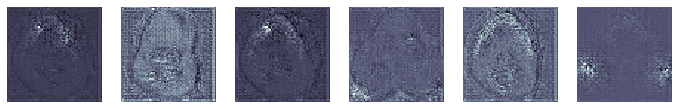

In [107]:
test=output.detach()
imgs_display(test)